# Comparison of CNN Architectures on CIFAR-10 Dataset

# Problem 1
- The provided code is intended to create a basic Convolutional Neural Network (CNN) for image classification using the CIFAR-10 dataset, which consists of images from 10 distinct categories. It leverages the torchvision library to download, split, and preprocess the images in the dataset.








cuda:0


100%|██████████| 170498071/170498071 [00:15<00:00, 11196923.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


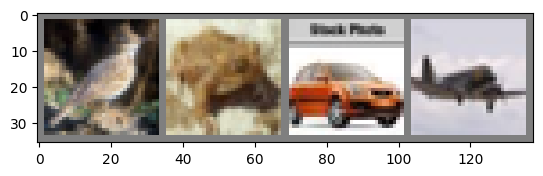

bird  frog  car   plane
[1,  2000] loss: 2.193
[1,  4000] loss: 1.816
[1,  6000] loss: 1.636
[1,  8000] loss: 1.544
[1, 10000] loss: 1.504
[1, 12000] loss: 1.446
[2,  2000] loss: 1.378
[2,  4000] loss: 1.366
[2,  6000] loss: 1.313
[2,  8000] loss: 1.308
[2, 10000] loss: 1.306
[2, 12000] loss: 1.278
Finished Training


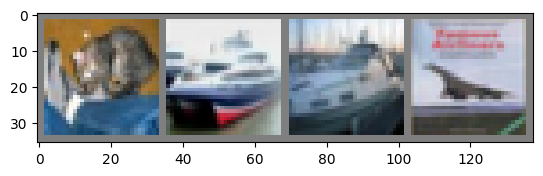

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   ship  ship 


<ipython-input-2-b0dd5f9060d3>:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 55 %
Accuracy for class: plane is 53.8 %
Accuracy for class: car   is 71.9 %
Accuracy for class: bird  is 52.6 %
Accuracy for class: cat   is 36.4 %
Accuracy for class: deer  is 51.2 %
Accuracy for class: dog   is 42.5 %
Accuracy for class: frog  is 49.6 %
Accuracy for class: horse is 60.9 %
Accuracy for class: ship  is 73.2 %
Accuracy for class: truck is 65.3 %


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# These two lines can be used in case you have multiple versions of the OpenMP library
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


########################################################################
# How do we run these neural networks on the GPU?
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor onto the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

########################################################################
# .. note::
#     If running on Windows and you get a BrokenPipeError, try setting
#     the num_worker of torch.utils.data.DataLoader() to 0.

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4     #You can change the batch size if you receive an out of memory error

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to unnormalize and show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


########################################################################
# 2. Define a Convolutional Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

########################################################################
# 4. Train the network
# ^^^^^^^^^^^^^^^^^^^^
#
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize.

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

########################################################################
# Let's quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

########################################################################
# Next, let's load back in our saved model (note: saving and re-loading the model
# wasn't necessary here, we only did it to illustrate how to do so):

net = Net()
net.load_state_dict(torch.load(PATH))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# The higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

########################################################################
# That looks way better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network has learned something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


## Printing Dimensions

In [ ]:
# Define a function to print the feature map sizes
def print_feature_map_sizes():
    # Create a dummy input of size (1, 3, 32, 32) as CIFAR-10 images have shape 32x32x3
    dummy_input = torch.randn(1, 3, 32, 32)

    # Pass through the first convolutional layer
    out_conv1 = net.conv1(dummy_input)
    print(f"Dimensions after first convolutional layer (before pooling): {out_conv1.shape}")

    # Pass through the first pooling layer
    out_pool1 = net.pool(out_conv1)
    print(f"Dimensions after first pooling layer: {out_pool1.shape}")

    # Pass through the second convolutional layer
    out_conv2 = net.conv2(out_pool1)
    print(f"Dimensions after second convolutional layer (before second pooling): {out_conv2.shape}")

    # Pass through the second pooling layer
    out_pool2 = net.pool(out_conv2)
    print(f"Dimensions after second pooling layer: {out_pool2.shape}")

# Run the function to print dimensions
print_feature_map_sizes()


Dimensions after first convolutional layer (before pooling): torch.Size([1, 6, 28, 28])
Dimensions after first pooling layer: torch.Size([1, 6, 14, 14])
Dimensions after second convolutional layer (before second pooling): torch.Size([1, 16, 10, 10])
Dimensions after second pooling layer: torch.Size([1, 16, 5, 5])


## Continuing Main Code with 20 Epochs

Epoch [1/20], Average Loss: 1.9799
Epoch [2/20], Average Loss: 1.9861
Epoch [3/20], Average Loss: 1.9830
Epoch [4/20], Average Loss: 1.9887
Epoch [5/20], Average Loss: 1.9694
Epoch [6/20], Average Loss: 1.9747
Epoch [7/20], Average Loss: 1.9587
Epoch [8/20], Average Loss: 1.9641
Epoch [9/20], Average Loss: 1.9484
Epoch [10/20], Average Loss: 1.9680
Epoch [11/20], Average Loss: 1.9614
Epoch [12/20], Average Loss: 2.0299
Epoch [13/20], Average Loss: 1.9706
Epoch [14/20], Average Loss: 1.9698
Epoch [15/20], Average Loss: 1.9665
Epoch [16/20], Average Loss: 1.9630
Epoch [17/20], Average Loss: 1.9639
Epoch [18/20], Average Loss: 1.9612
Epoch [19/20], Average Loss: 1.9588
Epoch [20/20], Average Loss: 1.9380


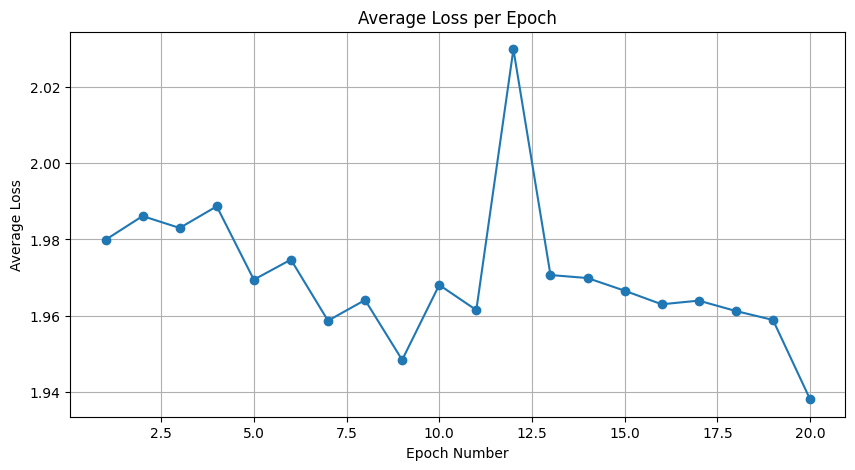

In [ ]:
import matplotlib.pyplot as plt

# Changing the number of epochs to 20
num_epochs = 20

# Storing the average loss for each epoch
epoch_losses = []

# Training the network with 20 epochs
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    total_batches = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        total_batches += 1

    # Calculating the average loss for the epoch
    avg_loss = running_loss / total_batches
    epoch_losses.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Plotting the average loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.grid()
plt.show()

## Modifying Main Code with 20 Epochs and Seeing the Training Rate for Better Results

---



Running on device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 2000] loss: 2.222
[Epoch 1, Batch 4000] loss: 1.872
[Epoch 1, Batch 6000] loss: 1.703
[Epoch 1, Batch 8000] loss: 1.612
[Epoch 1, Batch 10000] loss: 1.520
[Epoch 1, Batch 12000] loss: 1.504
Epoch 1 completed with Average Loss: 1.7280
[Epoch 2, Batch 2000] loss: 1.380
[Epoch 2, Batch 4000] loss: 1.393
[Epoch 2, Batch 6000] loss: 1.356
[Epoch 2, Batch 8000] loss: 1.341
[Epoch 2, Batch 10000] loss: 1.320
[Epoch 2, Batch 12000] loss: 1.288
Epoch 2 completed with Average Loss: 1.3425
[Epoch 3, Batch 2000] loss: 1.215
[Epoch 3, Batch 4000] loss: 1.212
[Epoch 3, Batch 6000] loss: 1.210
[Epoch 3, Batch 8000] loss: 1.204
[Epoch 3, Batch 10000] loss: 1.209
[Epoch 3, Batch 12000] loss: 1.164
Epoch 3 completed with Average Loss: 1.2025
[Epoch 4, Batch 2000] loss: 1.126
[Epoch 4, Batch 4000] loss: 1.115
[Epoch 4, Batch 6000] loss: 1.134
[Epoch 4, Batch 8000] loss: 1.116
[Epoch 4, Ba

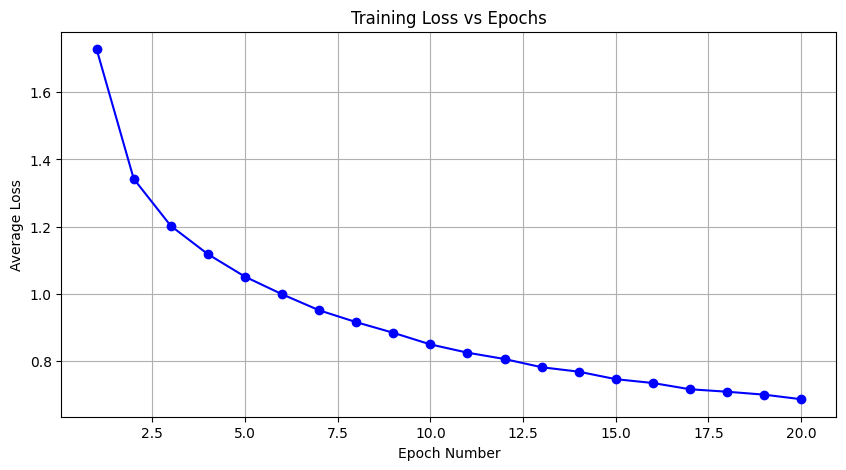

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Setting up environment to avoid OpenMP library issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Defining device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

# Transforming for normalization and conversion to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading CIFAR10 dataset
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Defining CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network with 20 epochs
epochs = 20
average_loss_per_epoch = []

for epoch in range(epochs):  # Training loop for 20 epochs
    running_loss = 0.0
    epoch_loss = 0.0
    total_batches = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()
        epoch_loss += loss.item()
        total_batches += 1

        # Print statistics every 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Calculate average loss for the epoch
    average_epoch_loss = epoch_loss / total_batches
    average_loss_per_epoch.append(average_epoch_loss)
    print(f'Epoch {epoch + 1} completed with Average Loss: {average_epoch_loss:.4f}')

print('Finished Training')

# Saving the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Plotting the average loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), average_loss_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.grid()
plt.show()

## Total Average Training Accuracy after 20 epochs

In [ ]:
# Calculating the accuracy of the trained model on the entire training dataset
total_correct_train = 0
total_train_samples = 0

# Putting the network in evaluation mode (this disables dropout and batch normalization)
net.eval()

# Ignoring tracking gradients
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = net(inputs)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Count the correct predictions
        total_train_samples += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

# Calculating the total average training accuracy
total_train_accuracy = 100 * total_correct_train / total_train_samples
print(f'Total Average Training Accuracy after 20 epochs: {total_train_accuracy:.2f}%')

Total Average Training Accuracy after 20 epochs: 78.88%


## Total Average Testing Accuracy after 20 epochs

In [ ]:
# Calculating the accuracy of the trained model on the entire testing dataset
total_correct_test = 0
total_test_samples = 0

# Putting the network in evaluation mode (this disables dropout and batch normalization)
net.eval()

# Ignoring tracking gradients
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the network
        outputs = net(inputs)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)

        # Count the total number of correct predictions
        total_test_samples += labels.size(0)
        total_correct_test += (predicted == labels).sum().item()

# Calculating the total average testing accuracy
total_test_accuracy = 100 * total_correct_test / total_test_samples
print(f'Total Average Testing Accuracy after 20 epochs: {total_test_accuracy:.2f}%')

Total Average Testing Accuracy after 20 epochs: 60.05%


# Problem 2
- For the given network and dataset, we add an extra convolutional layer with 10 filters, each of size 3x3, followed by max pooling after the existing pooling layer. The subsequent layers' dimensions are modified to match the added layers. The number of training epochs is also changed to 20.

Running on device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 2000] loss: 2.304
[Epoch 1, Batch 4000] loss: 2.225
[Epoch 1, Batch 6000] loss: 2.018
[Epoch 1, Batch 8000] loss: 1.874
[Epoch 1, Batch 10000] loss: 1.792
[Epoch 1, Batch 12000] loss: 1.713
Epoch 1 completed with Average Loss: 1.9752
[Epoch 2, Batch 2000] loss: 1.642
[Epoch 2, Batch 4000] loss: 1.594
[Epoch 2, Batch 6000] loss: 1.585
[Epoch 2, Batch 8000] loss: 1.533
[Epoch 2, Batch 10000] loss: 1.536
[Epoch 2, Batch 12000] loss: 1.519
Epoch 2 completed with Average Loss: 1.5670
[Epoch 3, Batch 2000] loss: 1.487
[Epoch 3, Batch 4000] loss: 1.482
[Epoch 3, Batch 6000] loss: 1.484
[Epoch 3, Batch 8000] loss: 1.474
[Epoch 3, Batch 10000] loss: 1.434
[Epoch 3, Batch 12000] loss: 1.444
Epoch 3 completed with Average Loss: 1.4670
[Epoch 4, Batch 2000] loss: 1.410
[Epoch 4, Batch 4000] loss: 1.414
[Epoch 4, Batch 6000] loss: 1.413
[Epoch 4, Batch 8000] loss: 1.390
[Epoch 4, Ba

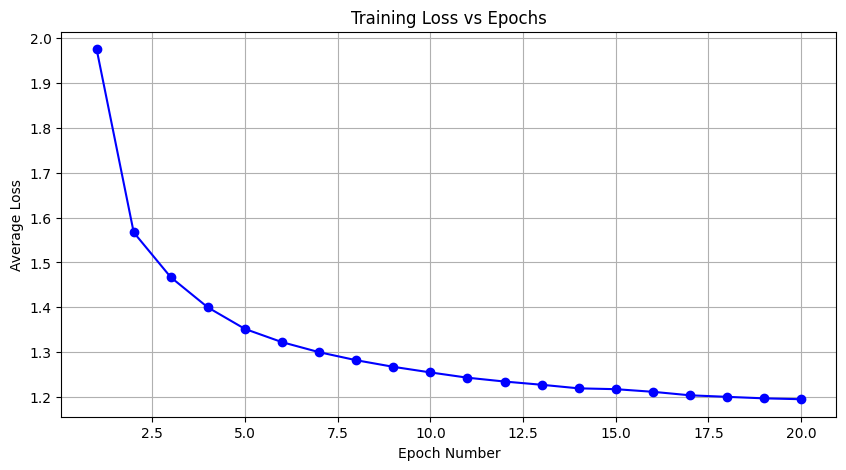

Total Average Training Accuracy after 20 epochs: 58.53%
Total Average Testing Accuracy after 20 epochs: 54.80%


In [ ]:
# Setting up environment to avoid OpenMP library issues
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Defining device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

# Transforming for normalization and conversion to tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading CIFAR10 dataset
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Defining a Modified CNN model with an extra convolutional layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)       # First convolutional layer
        self.pool1 = nn.MaxPool2d(2, 2)        # First max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5)       # Second convolutional layer
        self.pool2 = nn.MaxPool2d(2, 2)        # Second max pooling layer
        self.conv3 = nn.Conv2d(16, 10, 3)      # Third convolutional layer (new layer)
        self.pool3 = nn.MaxPool2d(2, 2)        # Third max pooling layer (new)

        # Adjust the dimensions of the linear layers accordingly
        self.fc1 = nn.Linear(10 * 1 * 1, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the modified network
net = Net().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network with 20 epochs and tracking the average loss for each epoch
epochs = 20
average_loss_per_epoch = []

for epoch in range(epochs):  # Training loop for 20 epochs
    running_loss = 0.0
    epoch_loss = 0.0
    total_batches = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()
        epoch_loss += loss.item()
        total_batches += 1

        # Print statistics every 2000 mini-batches
        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Calculating average loss for the epoch
    average_epoch_loss = epoch_loss / total_batches
    average_loss_per_epoch.append(average_epoch_loss)
    print(f'Epoch {epoch + 1} completed with Average Loss: {average_epoch_loss:.4f}')

print('Finished Training')

# Saving the trained model
PATH = './modified_cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 1. Plotting the average loss for each epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), average_loss_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Average Loss')
plt.grid()
plt.show()

# 2. Calculating the average accuracy of the training dataset
total_correct_train = 0
total_train_samples = 0
net.eval()

with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total_train_samples += labels.size(0)
        total_correct_train += (predicted == labels).sum().item()

total_train_accuracy = 100 * total_correct_train / total_train_samples
print(f'Total Average Training Accuracy after {epochs} epochs: {total_train_accuracy:.2f}%')

# 3. Calculating the average accuracy of the testing dataset
total_correct_test = 0
total_test_samples = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test_samples += labels.size(0)
        total_correct_test += (predicted == labels).sum().item()

total_test_accuracy = 100 * total_correct_test / total_test_samples
print(f'Total Average Testing Accuracy after {epochs} epochs: {total_test_accuracy:.2f}%')